# Projet 3: Comparaison de méthode d’anomaly detection par self supervised learning

## Library imports

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score


import os   

## Hyperparameters

In [26]:
BATCH_SIZE = 128
RESIZE = 32
LATENT_DIM = 32

## Introduction

### Principe de l’AD
La détection d'anomalies regroupe les algorithmes visant à identifier les échantillons qui s'écartent des modèles normaux, en fonction de facteurs comme les étiquettes des données et le contexte d'application. Bien que la plupart des algorithmes pour les détecter soient similaires, on peut quand même les séparer en 4 catégories : une anomalie correspond à un échantillon issu d'une distribution différente de celle des instances normales, une aberration est un échantillon rare au sein de la distribution normale, une nouveauté représente un échantillon inédit issu d'une distribution non stationnaire, et la détection hors-distribution vise à identifier des échantillons ne correspondant à aucune classe d'entraînement. 

### Intérêt du SSL
Dans le cadre non supervisé de la détection d'anomalies, on suppose généralement que les données d'entraînement sont non étiquetées et sans bruit, avec une distribution identique aux données normales (ℙ≡ℙ+). Ce cadre suscite un grand intérêt car il permet d’apprendre les caractéristiques des données dans des espaces complexes et de haute dimension sans nécessiter d’échantillons annotés. Cela est particulièrement pertinent pour des cas comme les pièces d’avion, où les anomalies sont rares en raison du coût élevé, du temps de production, et de la faible quantité disponible pour l’entraînement.

### Principe du SSL
Les modèles SSL apprennent en résolvant des tâches basées sur des transformations ou perturbations appliquées aux données (par exemple, inpainting, colorisation). Après cette phase, un modèle est adapté à des tâches en aval, comme la détection d’anomalies, en utilisant les représentations pré-entraînées.

### État de l’art
Les méthodes d'apprentissage contrastif, élément clé de l'auto-supervision, ont récemment montré des performances remarquables, atteignant une précision comparable à celle des modèles supervisés et sont particulierement bien adapté au la détection d'anomalie.

### Présentation des données

#### Chargement des données

Les données ont été convertit de png à jpg pour diminuer largement la taille des données (de 5,1Go à 165Mo) et augmenter largement la vitesse de calcul.
Les perfomrances sont sensiblement les mêmes selon le format JPG ou PNG
A la fin, une étude de performance sera effectué avec le modèle le plus prometeur. 

Les datasets ont été modifiés pour correspondre aux demandes du projet et son téléchargeable depuis un dépot github séparé du code.

In [27]:
# Crée un chemin relatif basé sur le dossier actuel
dataset_path = os.path.join(os.getcwd(), '../data/')

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path, exist_ok=True)  # Crée le dossier et ses parents si nécessaire

    !git clone https://github.com/sourisimos/DATA_P3HDDL_MVTEC.git ../data/mvtec #Cloning mvtec dataset 
    !git clone https://github.com/sourisimos/DATA_P3HDDL_EW.git ../data/ew #Cloning ew datasets

    print(f"Dossiers téléchargés dans le dossier '{dataset_path}'.")


##### Engine wiring dataset

##### jpg dataset


In [28]:
# Define the transformations to apply to EW

transform_ew_val = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.ToTensor()

])

transform_ew_train = transforms.Compose([
    transforms.Resize((RESIZE,RESIZE)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])


# Load EW dataset for train test and creating val
# Training
ew_train_dataset = datasets.ImageFolder(root='../data/ew/engine_wiring/train', transform=transform_ew_train)
ew_train_loader = DataLoader(ew_train_dataset, batch_size=BATCH_SIZE, shuffle=True )

# Test
ew_test_dataset = datasets.ImageFolder(root='../data/ew/engine_wiring/test', transform=transform_ew_val) 
ew_test_loader = DataLoader(ew_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### png dataset


In [29]:
# Define the transformations to apply to EW

transform_ew_val = transforms.Compose([
    transforms.Resize((RESIZE, RESIZE)),
    transforms.ToTensor()

])

transform_ew_train = transforms.Compose([
    transforms.Resize((RESIZE,RESIZE)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])


# Load EW dataset for train test and creating val
# Training
ew_train_dataset = datasets.ImageFolder(root='../data_png/engine_wiring/train', transform=transform_ew_train)
ew_train_loader = DataLoader(ew_train_dataset, batch_size=BATCH_SIZE, shuffle=True )

# Test
ew_test_dataset = datasets.ImageFolder(root='../data_png/engine_wiring/test', transform=transform_ew_val) 
ew_test_loader = DataLoader(ew_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


##### MVtec datasets

In [30]:
# Define the transformations to apply to the images
transform_mvtec = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
])

# Function to load the dataset mvtec 
def load_mvt_dataset(root='../data/mvtec/mvtec_anomaly_detection', batch_size=64, restricted = True):
    # List of categories you want to load
    categories = ['bottle', 'cable','capsule', 'carpet', 'grid','hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']  # Add other categories as needed
    # Restricted are just the essential one (for the academ project )
    if restricted: 
        categories = ['bottle','capsule', 'hazelnut', 'toothbrush']
        
    # Create dictionaries to hold loaders for training and test sets
    train_loaders = {}
    test_loaders = {}
    
    for category in categories:

        train_dataset = datasets.ImageFolder(root=f'{root}/{category}/train', transform=transform_mvtec)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_loaders[category] = train_loader
        
        test_dataset = datasets.ImageFolder(root=f'{root}/{category}/test', transform=transform_mvtec)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        test_loaders[category] = test_loader
        
    return train_loaders, test_loaders

train_loaders, test_loaders = load_mvt_dataset()

train_loaders['ew'] = ew_train_loader
test_loaders['ew'] = ew_test_loader

# Accessing a specific category's data loader
bottle_train_loader = train_loaders['bottle']
bottle_test_loader = test_loaders['bottle']

#### Affichage de quelques données

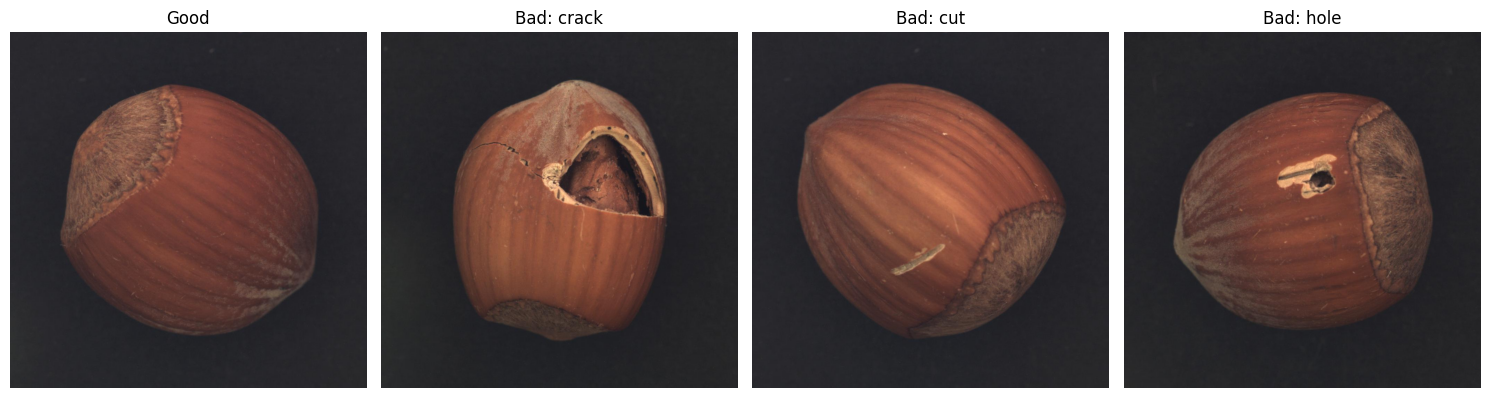

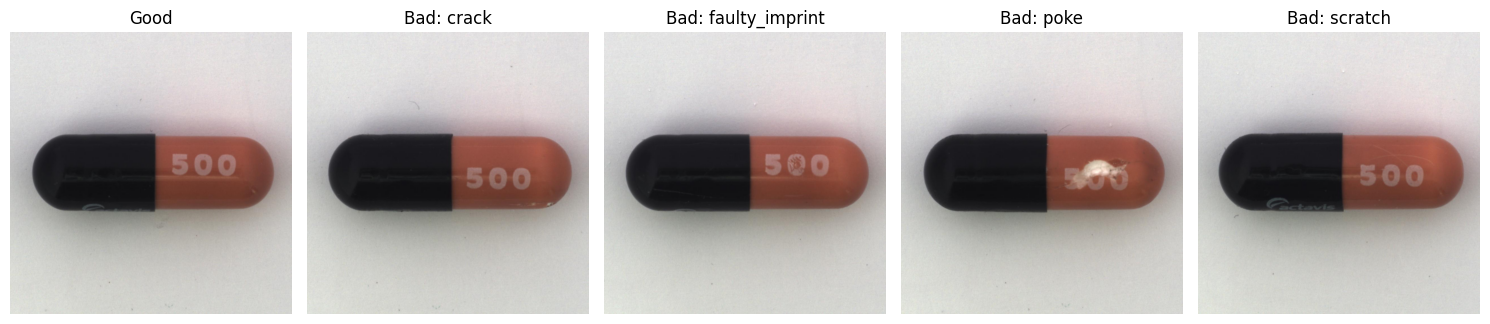

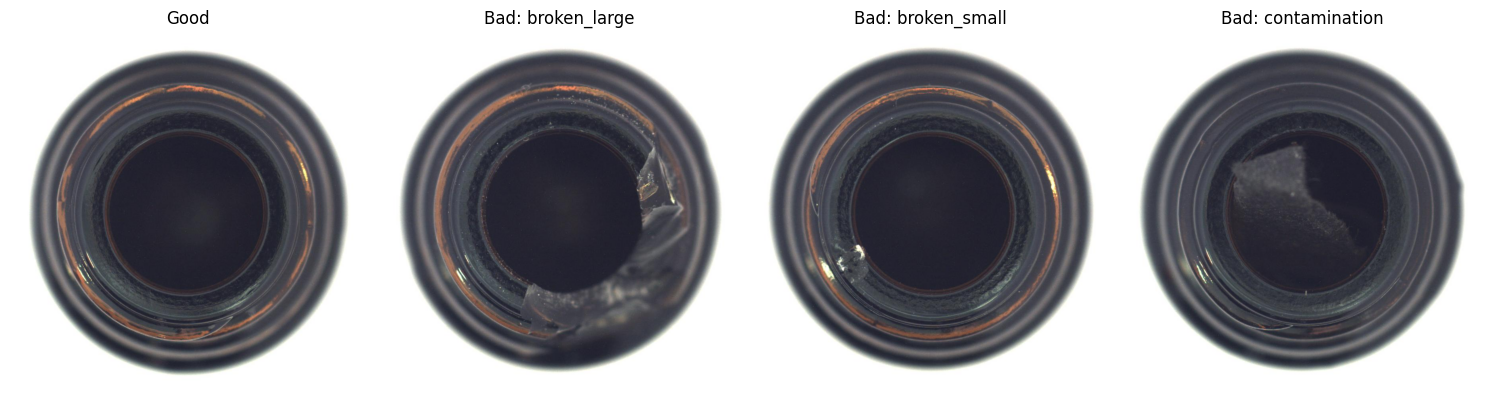

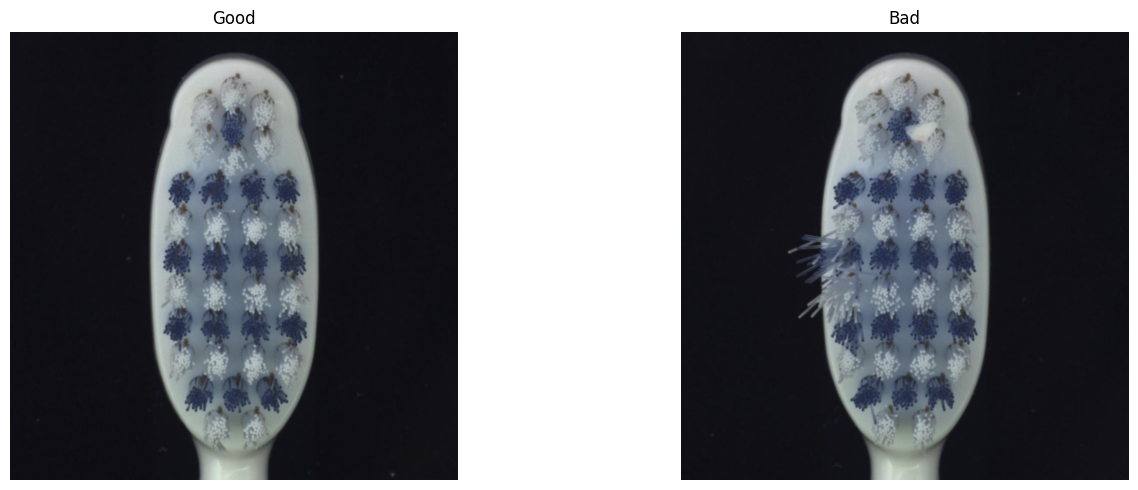

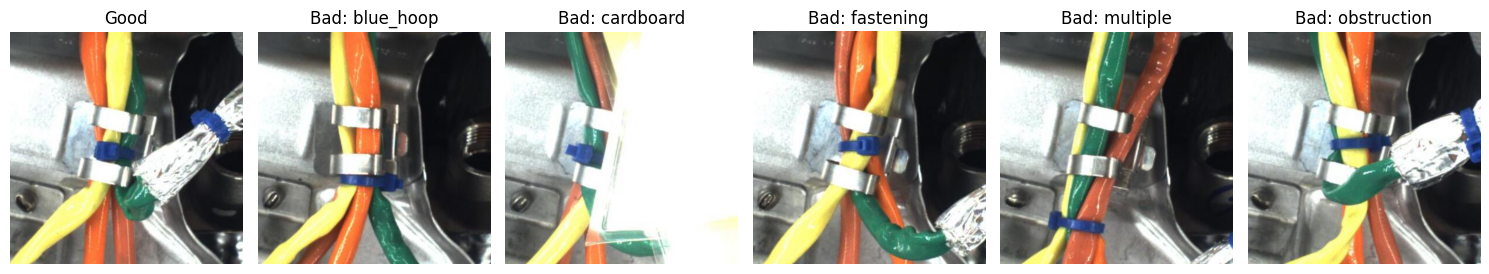

In [31]:
from print import display_images_from_folders

display_images_from_folders(path="data/mvtec/mvtec_anomaly_detection/hazelnut/test", num_good=1, num_bad=3)
display_images_from_folders(path="data/mvtec/mvtec_anomaly_detection/capsule/test", num_good=1, num_bad=4)
display_images_from_folders(path="data/mvtec/mvtec_anomaly_detection/bottle/test", num_good=1, num_bad=3)
display_images_from_folders(path="data/mvtec/mvtec_anomaly_detection/toothbrush/test", num_good=1, num_bad=1)
display_images_from_folders(path="data/ew/engine_wiring/test", num_good=1, num_bad=5)

#### Difficultés des données à priori
On remarque que Hazelnut semble assez simple comme tache, là ou capsule par exemple peut être difficile. 
On se concentre donc dans un premier temps sur hazelnut pour construire nos modeles et les vérifier.

#### Proportion test/train, absence de validation, et quantité
On possède assez peut de donner d'entrainement, on utilise donc la validation croisée lors de l'entrainement. On peut aussi faire de l'augmentation de donnée est à éviter de façon général car peut nuire à la compréhesnion du model et doit être spécific au jeu de donnée. Par simplicité on ne fait pas d'augmentation de données ici. 

## 2. Présentation des structures communes

### Encoder et Decoder

Encoder : ResNet18 est utilisé pour sa simplicité, sa robustesse et sa rapidité. Bien qu’il existe des modèles plus complexes, ResNet18 offre un bon compromis entre performances et coût computationnel.

Decoder : Le décodeur une structure symétrique de l’encodeur, avec des couches transposées pour reconstruire l’entrée

In [32]:
from torchvision.models import resnet18

class ResNet18Encoder(nn.Module):
    def __init__(self, in_channels, pretrained=True):
        super(ResNet18Encoder, self).__init__()
        assert in_channels in [1, 3], "Seuls 1 ou 3 canaux sont supportés pour le moment."

        resnet = resnet18(pretrained=pretrained)
        old_conv1 = resnet.conv1  # Conserver les anciens paramètres

        # Nouvelle couche convolutive avec le bon nombre de canaux
        resnet.conv1 = nn.Conv2d(in_channels, old_conv1.out_channels,
                                 kernel_size=old_conv1.kernel_size,
                                 stride=old_conv1.stride,
                                 padding=old_conv1.padding,
                                 bias=old_conv1.bias is not None)

        # Copier les poids des canaux existants si l'entrée a 1 canal (par ex., niveaux de gris)
        if in_channels == 1:
            resnet.conv1.weight.data = old_conv1.weight.data.mean(dim=1, keepdim=True)

        # Garder uniquement les couches convolutives jusqu'à la dernière convolution
        self.features = nn.Sequential(*list(resnet.children())[:-2])  # Jusqu'à "avgpool"

    def forward(self, x):
        return self.features(x)


class ResNet18Decoder(nn.Module):
    def __init__(self, out_channels):
        super(ResNet18Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, out_channels, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
            nn.Sigmoid()  # Contraindre la sortie dans [0, 1]
        )

    def forward(self, x):
        return self.decoder(x)


## Présentation des modèles

### Colorisation Autoencodeur : fonctionnement
Ce modèle apprend à coloriser une image en nuances de gris. La tâche force l’encodeur à capturer des caractéristiques sémantiques pertinentes.

In [33]:
class ColorizationResNetModel(nn.Module):
    def __init__(self):
        super(ColorizationResNetModel, self).__init__()
        self.encoder = ResNet18Encoder(in_channels=1)  # Input grayscale
        self.decoder = ResNet18Decoder(out_channels=3)  # Predict RGB

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)  # Convert RGB to Grayscale
        z = self.encoder(grayscale_x)
        return self.decoder(z), grayscale_x

### Inpainting Autoencodeur
 L’inpainting consiste à prédire des pixels manquants dans une image. Cela contraint le modèle à comprendre le contexte global de l’image.

In [34]:
class InpaintingModel(nn.Module):
    def __init__(self, mask_size=8):
        super(InpaintingModel, self).__init__()
        self.encoder = ResNet18Encoder(in_channels=3)  # Input grayscale
        self.decoder = ResNet18Decoder(out_channels=3)  # Predict RGB
        self.mask_size = mask_size

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked
    
    def apply_mask(self, x):
        masked_x = x.clone()

        for i in range(masked_x.size(0)):
            ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)
            ul_y = np.random.randint(0, x.size(3) - self.mask_size + 1)
            masked_x[i, :, ul_x:ul_x+self.mask_size, ul_y:ul_y+self.mask_size] = 0

        return masked_x

### 3.c. Masked Autoencodeur
Basé sur un masque aléatoire des pixels d’entrée, ce modèle apprend à reconstruire les parties masquées, un principe similaire à BERT pour le texte.

In [35]:
class MaskedAutoencoderModel(nn.Module):
    def __init__(self, mask_ratio=1/16):
        super(MaskedAutoencoderModel, self).__init__()
        self.encoder = ResNet18Encoder(in_channels=3)
        self.decoder = ResNet18Decoder(out_channels=3)
        self.mask_ratio = mask_ratio

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked
        
    
    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)
        x_masked[mask] = 0
        return x_masked

### Méthode d'entrainement
Pour ces trois modèles on utilise une méthode d'entrainement standard. L'optimizer Adam est choisi pour sa robustesse et sa capacité à s’adapter à des gradients variés. On utilise la loss MSE qui est adaptée pour la reconstruction d'image


In [36]:
def train_ssl_AE(model, 
                    train_loader, 
                    val_loader, 
                    criterion,
                    optimizer,
                    device=device,
                    epochs=5):
    model.to(device)
    hist_test_loss = []
    hist_val_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            
            output, _ = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        hist_test_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                output, _ = model(images)
                val_loss = criterion(output, images)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        hist_val_loss.append(hist_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")
    
    return hist_test_loss, hist_val_loss

In [37]:
import torch
import torch.nn as nn

class AnomalyDetectionModel(nn.Module):
    def __init__(self, model):
        super(AnomalyDetectionModel, self).__init__()
        self.model = model  # Modèle de reconstruction pré-entraîné

    def forward(self, x):
        # Le modèle principal doit retourner une reconstruction
        # Si le modèle retourne un tuple, on ne garde que la reconstruction
        if isinstance(self.model(x), tuple):
            x_reconstructed, _ = self.model(x)
        else:
            x_reconstructed = self.model(x)
        return x_reconstructed

    def compute_anomaly_score(self, x):
        """
        Calcule le score d'anomalie pour chaque batch d'images.
        """
        x_reconstructed = self.forward(x)  # Reconstruction
        loss_fn = nn.MSELoss(reduction='none')  # MSE pixel par pixel
        per_pixel_loss = loss_fn(x_reconstructed, x)  # Perte pixel par pixel
        # Moyenne sur les dimensions des pixels (H, W, C) pour obtenir un score par image
        anomaly_score = per_pixel_loss.mean(dim=(1, 2, 3))
        return anomaly_score

    def evaluate_anomaly_detection(self, dataloader):

        self.model.eval()  # Mettre le modèle en mode évaluation
        scores = []  # Liste pour stocker les scores
        labels = []  # Liste pour stocker les labels
        with torch.no_grad():  # Pas de calcul des gradients
            for batch, label in dataloader:
                # Charger les données et les labels sur le bon appareil (CPU/GPU)
                x = batch.to(device)
                label = label.to(device)
                # Calculer les scores d'anomalie
                score = self.compute_anomaly_score(x)
                scores.extend(score.cpu().numpy())  # Convertir en numpy et ajouter à la liste
                labels.extend(label.cpu().numpy())  # Convertir en numpy et ajouter à la liste
        return scores, labels

def compute_anomaly_score(x_reconstructed, x):

    loss_fn = nn.MSELoss(reduction='none')  # MSE pixel par pixel
    per_pixel_loss = loss_fn(x_reconstructed, x)  # Perte pixel par pixel
    # Moyenne sur les dimensions des pixels (H, W, C) pour obtenir un score par image
    anomaly_score = per_pixel_loss.mean(dim=(1, 2, 3))
    return anomaly_score

### Méthodes contrastives

#### Fonctionnement
Les méthodes contrastives apprennent des représentations robustes en comparant les similitudes et différences entre paires d'échantillons. L'idée principale est :

Maximisation de la similarité : Les représentations de deux transformations différentes d'une même image doivent être proches dans l'espace latent.
Minimisation de la dissimilarité : Les représentations des échantillons issus d'images différentes doivent être éloignées.

Ces méthodes exploitent des augmentations de données pour créer des paires positives (deux transformations d'une même image) et négatives (des images différentes). Les réseaux comme ResNet sont souvent utilisés comme encoders pour produire des embeddings.

#### Adaptation des données

In [40]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]
    
# Define the transformations to apply to the images
contrast_transform = transforms.Compose([ transforms.Resize((128, 128)), # fait à la fin pour conserver le plus d'infos lors des étapes de transfo
                                          transforms.RandomHorizontalFlip(),
                                           transforms.RandomResizedCrop(size=128),
#                                          transforms.RandomApply([
#                                              transforms.ColorJitter(brightness=0.5,
#                                                                     contrast=0.5,
#                                                                     saturation=0.5,
#                                                                     hue=0.1)
#                                          ], p=0.8),
#                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                         ])

# EW Datasets load
ew_train_dataset_cm = datasets.ImageFolder(root='../data/ew/engine_wiring/train', transform=ContrastiveTransformations(contrast_transform))
ew_train_loader_cm = DataLoader(ew_train_dataset, batch_size=BATCH_SIZE, shuffle=True )


# Function to load the dataset mvtec 
def load_mvt_dataset_cm(root='../data/mvtec/mvtec_anomaly_detection', batch_size=64, restricted = True):
    # List of categories you want to load
    categories = ['bottle', 'cable','capsule', 'carpet', 'grid','hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']  # Add other categories as needed
    # Restricted are just the essential one (for the academ project )
    if restricted: 
        categories = ['bottle','capsule', 'hazelnut', 'toothbrush']
        
    # Create dictionaries to hold loaders for training and test sets
    train_loaders = {}
    
    for category in categories:

        train_dataset = datasets.ImageFolder(root=f'{root}/{category}/train', transform=ContrastiveTransformations(contrast_transform))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_loaders[category] = train_loader
        
    return train_loaders

train_loaders_cm = load_mvt_dataset_cm()

# add ew dataloader to dict
train_loaders_cm["ew"] = ew_train_loader_cm


# Accessing a specific category's data loader
bottle_train_loader_cm = train_loaders_cm['hazelnut']


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


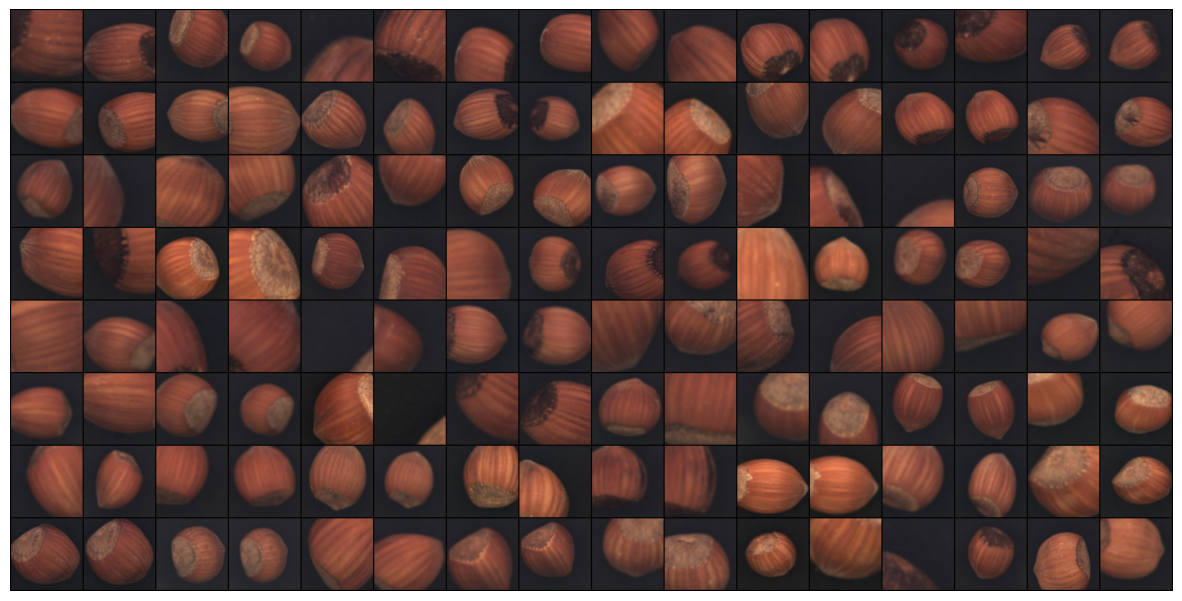

In [41]:
# Vérification des transformations
import matplotlib.pyplot as plt
import torchvision

# Récupérer un batch d'images
data_iter = iter(bottle_train_loader_cm)
(img1, img2), labels = next(data_iter)  # images contient le batch, labels les classes associées
print(labels)
images = torch.cat([torch.stack([img1[i], img2[i]]) for i in range(img1.size(0))], dim=0)# Faire une grille d'images
grid_img = torchvision.utils.make_grid(images, nrow=2*8)  # nrow = nombre d'images par ligne

# Convertir en numpy et afficher
plt.figure(figsize=(15, 15))  # Ajuster la taille de l'affichage
plt.imshow(grid_img.permute(1, 2, 0))  # PyTorch utilise (C, H, W), Matplotlib attend (H, W, C)
plt.axis('off')  # Enlever les axes pour une visualisation propre
plt.show()

##### Modèle

In [43]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128) 
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x))) 
        return self.fc2(x)


# Encoder basé sur ResNetz
class Contrastive_Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Contrastive_Encoder, self).__init__()
        resnet = resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer
        self.fc = nn.Linear(resnet.fc.in_features, latent_dim)

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        return self.fc(features)

# Modèle complet
class ContrastiveModel(nn.Module):
    def __init__(self, latent_dim=512, projection_dim=64):
        super(ContrastiveModel, self).__init__()
        self.encoder = Contrastive_Encoder(latent_dim=latent_dim)
        self.projection_head = ProjectionHead(input_dim=latent_dim, output_dim=projection_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return F.normalize(projections, p=2, dim=1)

#### Training
Données positives uniquement : En détection d'anomalies, les données utilisées pour l'entraînement sont souvent considérées comme normales. Le modèle apprend une représentation compacte de ces données normales, ce qui permet ensuite d'identifier les anomalies comme des déviations.
Processus :
Une image est transformée deux fois (ex. flip, rotation) pour générer une paire positive.
Un batch est formé avec des paires positives et des négatives simulées à partir d'images différentes.
Le modèle est entraîné pour rapprocher les paires positives et éloigner les négatives.

In [44]:
# Training loop for contrastive learning
def train_sll_contrastive(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    hist_test_loss = []
    hist_val_loss = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0        
        for (b_img1, b_img2), _ in train_loader:
            b_img1, b_img2 = b_img1.to(device), b_img2.to(device)

            optimizer.zero_grad()
            z1 = model(b_img1)
            z2 = model(b_img2)

            loss = criterion(z1, z2)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        hist_test_loss.append(avg_train_loss)
        """
        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for (img1, img2), _ in train_loader:
                img1, img2 = img1.to(device), img2.to(device)
                
                z1 = model(img1)
                z2 = model(img2)

                val_loss = criterion(z1, z2)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(train_loader)
        hist_val_loss.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")
        """
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

        return hist_test_loss, hist_val_loss
        



#### Fonction de perte dans les méthodes contrastives

Dans les méthodes contrastives, la fonction de perte (*loss*) est essentielle pour ajuster les distances entre les représentations latentes. Trois fonctions principales sont souvent utilisées : la Cosine Similarity Loss, la Euclidean Distance Loss et l'InfoNCE Loss.


##### Cosine Similarity Loss

- **Description** : Cette fonction mesure l'angle entre deux vecteurs (représentations latentes). Plus les vecteurs sont alignés, plus ils sont similaires.

- **Formule** :

$$
\text{Sim}(z_i, z_j) = \frac{z_i \cdot z_j}{\|z_i\| \|z_j\|} \text{ où } z_i \text{ et } z_j \text{ représentent les vecteurs de représentation des images transformées.}
$$

- **Avantage** : Cette fonction est insensible à l'échelle des vecteurs, ce qui est utile pour l'apprentissage des embeddings.


In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def SSLContrastiveLossCosine(z1, z2, margin=0.5):
    """
    Contrastive loss utilisant la similarité cosinus.

    Args:
        z1 (Tensor): Embeddings des transformations de l'image initiale (batch_size, embedding_dim).
        z2 (Tensor): Embeddings des autres transformations correspondantes (batch_size, embedding_dim).
        margin (float): Marge à appliquer pour séparer les paires négatives.

    Returns:
        loss (Tensor): Perte scalaire contrastive.
    """
    z1 = F.normalize(z1, p=2, dim=1)  # Normalisation des embeddings
    z2 = F.normalize(z2, p=2, dim=1)

    batch_size = z1.size(0)

    # Calculer la similarité cosinus entre toutes les paires
    all_similarities = torch.mm(z1, z2.T)  # Produit scalaire après normalisation (équivaut à cosine_similarity)

    # Masque pour les paires positives (diagonale)
    mask = torch.eye(batch_size, device=z1.device).bool()
    pos_similarities = all_similarities[mask]  # Similarité des paires positives (diagonale)
    neg_similarities = all_similarities[~mask]  # Similarité des paires négatives (hors diagonale)

    # Perte pour les paires positives : Maximiser la similarité (1 - cos_sim)
    pos_loss = torch.mean(1 - pos_similarities)

    # Perte pour les paires négatives : Minimiser la similarité si elle dépasse la marge
    neg_loss = torch.mean(torch.clamp(neg_similarities - margin, min=0.0)**2)

    # Perte totale
    loss = pos_loss + neg_loss

    return loss


##### Euclidean Distance Loss

- **Description** : Cette fonction minimise la distance euclidienne entre les représentations des paires positives et maximise celle des paires négatives.

- **Formule** :

$L = \sum \|z_i - z_j\|^2 \text{ où } z_i \text{ et } z_j \text{ représentent les vecteurs de représentation des images transformées.}$

- **Avantage** : Cette fonction donne un contrôle direct sur la distance entre les points dans l'espace latent.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def SSLContrastiveLossEuclid(z1, z2, margin=0.5):

    """
    Args:
        z_i: Tensor des embeddings des transformations de l'image initiale (batch_size, embedding_dim)
        z_j: Tensor des embeddings des autres transformations correspondantes (batch_size, embedding_dim)
    
    Returns:
        loss: Scalar tensor représentant la perte contrastive.
    """
    z1 = F.normalize(z1, p=2, dim=1)  # Normalisation des embeddings
    z2 = F.normalize(z2, p=2, dim=1)
    
    batch_size = z1.size(0)

    all_distances = torch.cdist(z1, z2, p=2)

    # Séparation des distances positives et négatives
    mask = torch.eye(batch_size, device=z1.device).bool()  # Masque pour les paires positives
    pos_distances = all_distances[mask]  # Distances positives (diagonale)
    neg_distances = all_distances[~mask]  # Distances négatives (hors diagonale)

    # Contrastive loss computation
    pos_loss = torch.mean(pos_distances**2)  # Positive pair loss
    # Normalisation par le nombre de paires

    
    num_negatives = neg_distances.numel()
    neg_loss = torch.sum(torch.clamp(margin - neg_distances, min=0.0)**2) / num_negatives

    # neg_loss = torch.mean(torch.clamp(margin - neg_distances, min=0.0)**2)  # Negative pair loss

    # Total loss
    loss = pos_loss + neg_loss

    return loss


##### InfoNCE Loss (commune en apprentissage contrastif)

- **Description** : Cette fonction combine les idées des deux pertes précédentes. Elle maximise une distribution probabiliste où une paire positive est plus probable que les négatives.

- **Formule** :
$ L = -\log \frac{\exp(\text{Sim}(z_i, z_j)/\tau)}{\sum_{k=1}^{N} \exp(\text{Sim}(z_i, z_k)/\tau)} \text{ où } \tau \text{ est une constante pour ajuster la température, et } N\text{  représente le nombre total d'images dans le batch.}$
- **Avantage** : Cette fonction permet une optimisation efficace et favorise des représentations discriminatives, même dans des environnements avec de nombreuses classes.


##### Résumé des Avantages

1. **Cosine Similarity Loss** :
   - Insensible à l'échelle des vecteurs, adaptée pour des tâches d'apprentissage contrastif.

2. **Euclidean Distance Loss** :
   - Contrôle direct sur la distance dans l'espace latent, facile à interpréter.

3. **InfoNCE Loss** :
   - Combine la similarité et les distributions négatives pour améliorer la robustesse, particulièrement utile pour des jeux de données complexes.


#### Détection d'anomali

In [ ]:
import torch

# Function to compute embeddings
def compute_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for x1, label in data_loader:
            z1 = model(x1)  # Use one augmented view for simplicity
            embeddings.append(z1)
            labels.extend(label.cpu().numpy())  # Convertir en numpy et ajouter à la liste
    embeddings = torch.cat(embeddings)
    return embeddings, labels

# Function to calculate anomaly scores
def compute_anomaly_scores(embeddings, normal_mean):
    distances = torch.norm(embeddings - normal_mean, dim=1)
    return distances


In [ ]:
def f1_tresh(anomaly_scores): 
    best_threshold = 0
    best_f1 = 0
    thresholds = torch.linspace(anomaly_scores.min(), anomaly_scores.max(), steps=100)

    for t in thresholds:
        preds = (anomaly_scores > t).int()
        f1 = f1_score(labels, preds.cpu().numpy())
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    return best_threshold

In [ ]:
def anomali_prediction(contrastiv_model, train_loader, test_loader, display=True):
    with torch.no_grad():
        embeddings_normales, _ = compute_embeddings(contrastiv_model, train_loader)
        embeddings_evaluation, labels = compute_embeddings(contrastiv_model, test_loader)

    normal_mean = torch.mean(embeddings_normales, dim=0)

    anomaly_scores = compute_anomaly_scores(embeddings_evaluation, normal_mean)

    # threshold = torch.quantile(anomaly_scores, 0.80)
    threshold = f1_tresh(anomaly_scores)

    # Predict anomalies
    predictions  = (anomaly_scores > threshold).int()
    predictions = predictions.cpu().numpy()
    
    if display:
        # Convertir les scores et labels en numpy pour manipulation facile
        anomaly_scores_np = anomaly_scores.cpu().numpy()
        labels_np = np.array(labels)

        # affichage de séparation les scores selon les labels
        scores_normales = anomaly_scores_np[labels_np == 0]
        scores_anomalies = anomaly_scores_np[labels_np == 1]
        plt.hist(scores_normales, bins=50, alpha=0.7, label="Normales", color="blue")
        plt.hist(scores_anomalies, bins=50, alpha=0.7, label="Anomalies", color="orange")
        plt.axvline(x=threshold, color='r', linestyle='--', label="Threshold")
        plt.title("Distribution of Anomaly Scores")
        plt.xlabel("Score")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()
    
    return predictions, labels

Anomaly Scores: tensor([0.0284, 0.0315, 0.0327, 0.0371, 0.0348, 0.0246, 0.0677, 0.0508, 0.0269,
        0.0308, 0.0399, 0.0401, 0.0449, 0.0437, 0.0406, 0.0503, 0.0390, 0.0383,
        0.0392, 0.0490, 0.0640, 0.0481, 0.0872, 0.0787, 0.0535, 0.0599, 0.1329,
        0.0561, 0.0889, 0.1194, 0.0853, 0.0403, 0.0831, 0.0953, 0.0388, 0.0402,
        0.0930, 0.0992, 0.0902, 0.1264, 0.1009, 0.0859, 0.0480, 0.1113, 0.1409,
        0.0760, 0.0991, 0.1011, 0.0744, 0.0879, 0.0774, 0.0939, 0.1100, 0.0509,
        0.0583, 0.1154, 0.1460, 0.1470, 0.1429, 0.0994, 0.0492, 0.1327, 0.0707,
        0.0572, 0.0649, 0.0663, 0.0586, 0.0887, 0.0868, 0.0486, 0.0966, 0.1479,
        0.0545, 0.1150, 0.0955, 0.0800, 0.0574, 0.0862, 0.0565, 0.0381, 0.0524,
        0.1025, 0.0668])
Threshold: 0.04574371501803398
Predictions (1=anomaly, 0=normal): [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1]
[0,

## 4. Présentation des résultats et analyses

#### Apprentissage des modèles

In [ ]:
dict_model = {"colo": {},
              'inp': {},
              'mae': {},
              'cont_cos': {},
              'cont_euc': {}}

mods = {"colo": ColorizationResNetModel, 'inp':InpaintingModel, "mae":MaskedAutoencoderModel}

loss_cont = {"cont_cos": SSLContrastiveLossCosine, 'cont_euc':SSLContrastiveLossEuclid}

for k in dict_model.key(): 
    if k == "colo" or k == "inp" or k == 'mae':
        model = mods[k]
        for key, data in train_loaders.item():
            hist_test_loss_col, hist_val_loss_col = train_ssl_AE(model, 
                                                data, 
                                                criterion=nn.MSELoss(), 
                                                optimizer=optim.Adam(model.parameters(),lr=0.01),
                                                epoch = 50
                                                )
            dict_model[k][key]['loss'] = [hist_test_loss_col, hist_val_loss_col]
            dict_model[k][key]['model'] = model

    elif k == "cont_cos" or k == "cont_euc":
        crit = loss_cont[k]
        model = ContrastiveModel()
        for key, data in train_loaders_cm.item(): 
            hist_test_loss_col, hist_val_loss_col = train_sll_contrastive(model, 
                                                    data, 
                                                    criterion=crit, 
                                                    optimizer=optim.Adam(model.parameters(),lr=0.0001),
                                                    epoch = 50
                                                    )
            dict_model[k][key]['loss'] = [hist_test_loss_col, hist_val_loss_col]
            dict_model[k][key]['model'] = model

In [ ]:
colorization_rensetmodel = ColorizationResNetModel()
hist_test_loss_col, hist_val_loss_col = train_ssl_AE(colorization_rensetmodel, 
                                            bottle_train_loader, 
                                            bottle_test_loader, 
                                            criterion=nn.MSELoss(), 
                                            optimizer=optim.Adam(colorization_rensetmodel.parameters(),lr=0.01),
                                            epochs = 20
                                            )

Epoch 1/20, Train Loss: 0.1894, Avg Val Loss: 0.3636
Epoch 2/20, Train Loss: 0.1249, Avg Val Loss: 0.3767
Epoch 3/20, Train Loss: 0.0993, Avg Val Loss: 0.3242
Epoch 4/20, Train Loss: 0.0548, Avg Val Loss: 0.2957
Epoch 5/20, Train Loss: 0.0227, Avg Val Loss: 0.2808
Epoch 6/20, Train Loss: 0.0149, Avg Val Loss: 0.2538
Epoch 7/20, Train Loss: 0.0129, Avg Val Loss: 0.1867
Epoch 8/20, Train Loss: 0.0119, Avg Val Loss: 0.1325
Epoch 9/20, Train Loss: 0.0103, Avg Val Loss: 0.0851
Epoch 10/20, Train Loss: 0.0088, Avg Val Loss: 0.0596
Epoch 11/20, Train Loss: 0.0082, Avg Val Loss: 0.0437
Epoch 12/20, Train Loss: 0.0077, Avg Val Loss: 0.0399
Epoch 13/20, Train Loss: 0.0073, Avg Val Loss: 0.0326
Epoch 14/20, Train Loss: 0.0070, Avg Val Loss: 0.0264
Epoch 15/20, Train Loss: 0.0069, Avg Val Loss: 0.0234
Epoch 16/20, Train Loss: 0.0067, Avg Val Loss: 0.0146
Epoch 17/20, Train Loss: 0.0065, Avg Val Loss: 0.0112
Epoch 18/20, Train Loss: 0.0065, Avg Val Loss: 0.0088
Epoch 19/20, Train Loss: 0.0063, Avg 

In [ ]:
inpainting_resnetmodel = InpaintingModel(mask_size=8)
hist_test_loss_inp, hist_val_loss_in = train_ssl_AE(inpainting_resnetmodel,
                                            bottle_train_loader, 
                                            bottle_test_loader, 
                                            criterion=nn.MSELoss(), 
                                            optimizer=optim.Adam(inpainting_resnetmodel.parameters(),lr=0.001),
                                            epochs = 20
                                            )

Epoch 1/20, Train Loss: 0.1308, Avg Val Loss: 0.1265
Epoch 2/20, Train Loss: 0.1147, Avg Val Loss: 0.0722
Epoch 3/20, Train Loss: 0.0695, Avg Val Loss: 0.0553
Epoch 4/20, Train Loss: 0.0627, Avg Val Loss: 0.0505
Epoch 5/20, Train Loss: 0.0455, Avg Val Loss: 0.0399
Epoch 6/20, Train Loss: 0.0305, Avg Val Loss: 0.0289
Epoch 7/20, Train Loss: 0.0218, Avg Val Loss: 0.0216
Epoch 8/20, Train Loss: 0.0177, Avg Val Loss: 0.0143
Epoch 9/20, Train Loss: 0.0141, Avg Val Loss: 0.0136
Epoch 10/20, Train Loss: 0.0126, Avg Val Loss: 0.0128
Epoch 11/20, Train Loss: 0.0108, Avg Val Loss: 0.0099
Epoch 12/20, Train Loss: 0.0088, Avg Val Loss: 0.0089
Epoch 13/20, Train Loss: 0.0075, Avg Val Loss: 0.0077
Epoch 14/20, Train Loss: 0.0065, Avg Val Loss: 0.0069
Epoch 15/20, Train Loss: 0.0057, Avg Val Loss: 0.0059
Epoch 16/20, Train Loss: 0.0049, Avg Val Loss: 0.0053
Epoch 17/20, Train Loss: 0.0043, Avg Val Loss: 0.0050
Epoch 18/20, Train Loss: 0.0039, Avg Val Loss: 0.0044
Epoch 19/20, Train Loss: 0.0035, Avg 

In [ ]:
mae_resnetmodel = MaskedAutoencoderModel(mask_ratio=1/16)
hist_test_loss_mae, hist_val_loss_mae = train_ssl_AE(mae_resnetmodel,
                                            bottle_train_loader, 
                                            bottle_test_loader, 
                                            criterion=nn.MSELoss(), 
                                            optimizer=optim.Adam(mae_resnetmodel.parameters(),lr=0.001),
                                            epochs = 20
                                            )

/home/hp/miniconda3/envs/HDDL/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hp/miniconda3/envs/HDDL/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.1234, Avg Val Loss: 0.1184
Epoch 2/20, Train Loss: 0.1020, Avg Val Loss: 0.1169
Epoch 3/20, Train Loss: 0.0941, Avg Val Loss: 0.1064
Epoch 4/20, Train Loss: 0.0893, Avg Val Loss: 0.0979
Epoch 5/20, Train Loss: 0.0836, Avg Val Loss: 0.0838
Epoch 6/20, Train Loss: 0.0672, Avg Val Loss: 0.0516
Epoch 7/20, Train Loss: 0.0358, Avg Val Loss: 0.0240
Epoch 8/20, Train Loss: 0.0175, Avg Val Loss: 0.0114
Epoch 9/20, Train Loss: 0.0086, Avg Val Loss: 0.0111
Epoch 10/20, Train Loss: 0.0056, Avg Val Loss: 0.0165
Epoch 11/20, Train Loss: 0.0047, Avg Val Loss: 0.0159
Epoch 12/20, Train Loss: 0.0042, Avg Val Loss: 0.0142
Epoch 13/20, Train Loss: 0.0038, Avg Val Loss: 0.0099
Epoch 14/20, Train Loss: 0.0035, Avg Val Loss: 0.0075
Epoch 15/20, Train Loss: 0.0034, Avg Val Loss: 0.0049
Epoch 16/20, Train Loss: 0.0032, Avg Val Loss: 0.0042
Epoch 17/20, Train Loss: 0.0030, Avg Val Loss: 0.0043
Epoch 18/20, Train Loss: 0.0029, Avg Val Loss: 0.0047
Epoch 19/20, Train Loss: 0.0027, Avg 

In [ ]:
contrastiv_model_cos = ContrastiveModel(projection_dim=64)

hist_test_loss_cont_cos, hist_val_loss_cont_cos = train_sll_contrastive(contrastiv_model_cos, 
                                            bottle_train_loader_cm, 
                                            bottle_test_loader_cm, 
                                            criterion=SSLContrastiveLossCosine, 
                                            optimizer=optim.Adam(contrastiv_model_cos.parameters(),lr=1e-4),
                                            epochs = 20
                                            )

/home/hp/miniconda3/envs/HDDL/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hp/miniconda3/envs/HDDL/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.9748
Epoch 2/20, Train Loss: 0.7624
Epoch 3/20, Train Loss: 0.5398
Epoch 4/20, Train Loss: 0.3733
Epoch 5/20, Train Loss: 0.2783
Epoch 6/20, Train Loss: 0.2312
Epoch 7/20, Train Loss: 0.1880
Epoch 8/20, Train Loss: 0.1654
Epoch 9/20, Train Loss: 0.1490
Epoch 10/20, Train Loss: 0.1168
Epoch 11/20, Train Loss: 0.1011
Epoch 12/20, Train Loss: 0.0909
Epoch 13/20, Train Loss: 0.1108
Epoch 14/20, Train Loss: 0.0774
Epoch 15/20, Train Loss: 0.0689
Epoch 16/20, Train Loss: 0.0625
Epoch 17/20, Train Loss: 0.0785
Epoch 18/20, Train Loss: 0.0646
Epoch 19/20, Train Loss: 0.0582
Epoch 20/20, Train Loss: 0.0618


In [ ]:
contrastiv_model_euc = ContrastiveModel(projection_dim=64)

hist_test_loss_cont_euc, hist_val_loss_cont_euc = train_sll_contrastive(contrastiv_model_euc, 
                                            bottle_train_loader_cm, 
                                            bottle_test_loader_cm, 
                                            criterion=SSLContrastiveLossEuclid, 
                                            optimizer=optim.Adam(contrastiv_model_euc.parameters(),lr=1e-4),
                                            epochs = 20
                                            )

### 4.d. Justification du pas, nombre d’époques

### 4.a. Sur-apprentissage ?

### 4.c. Performance à convergence (ROC C)

In [6]:
def plot_roc_curve(y_true, y_scores):

    # Calcul des courbes ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Tracé de la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance level')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    return roc_auc

In [ ]:
dict_model = {"colo": {},
              'inp': {},
              'mae': {},
              'cont_cos': {},
              'cont_euc': {}}

mods = {"colo": ColorizationResNetModel, 'inp':InpaintingModel, "mae":MaskedAutoencoderModel}

loss_cont = {"cont_cos": SSLContrastiveLossCosine, 'cont_euc':SSLContrastiveLossEuclid}

for k in dict_model.key(): 
    model = dict_model[k][key]['model']
    if k == "colo" or k == "inp" or k == 'mae':
        model_anomali = AnomalyDetectionModel(model)
        # Plotting roc curbe
        for key, data in test_loaders.item():
            scores, labels = model_anomali.evaluate_anomaly_detection(data)
            auc = plot_roc_curve(labels, scores)

            dict_model[k][key]['auc'] = auc
            dict_model[k][key]['pred'] = [scores, labels]


    elif k == "cont_cos" or k == "cont_euc":
        model = dict_model[k][key]['model']

        # Plotting roc curbe
        for key, data in test_loaders.item():
            scores, labels = anomali_prediction(model, train_loaders['key'], data, display=True)
            auc = plot_roc_curve(labels, scores)

            dict_model[k][key]['auc'] = auc
            dict_model[k][key]['pred'] = [scores, labels]
    


### 4.e. Analyse des séparations via les graphiques

### 4.b. Temps de calcul

# Résults

#### Color anomali

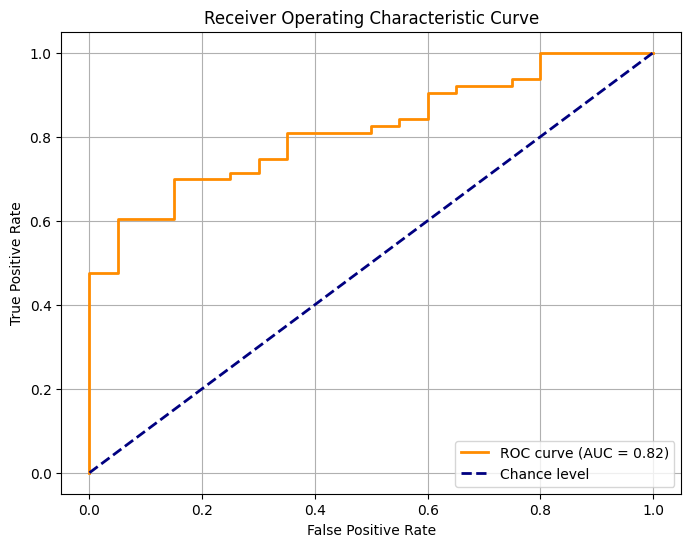

In [27]:
color_anomali = AnomalyDetectionModel(colorization_rensetmodel)

scores, labels = color_anomali.evaluate_anomaly_detection(bottle_test_loader)

# Plotting roc curbe
plot_roc_curve(labels, scores)

#### Inpainting anomali

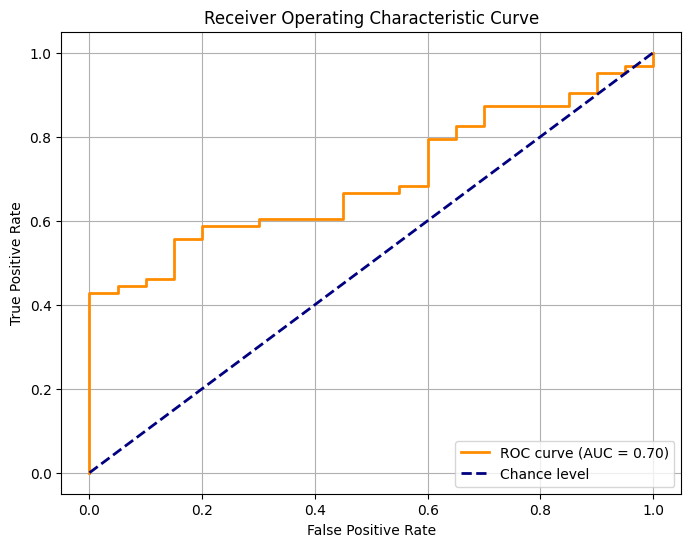

In [46]:
inpainting_anomali = AnomalyDetectionModel(inpainting_resnetmodel)


scores, labels = inpainting_anomali.evaluate_anomaly_detection(bottle_test_loader)

# Plotting roc curbe
plot_roc_curve(labels, scores)

#### MAE anomali

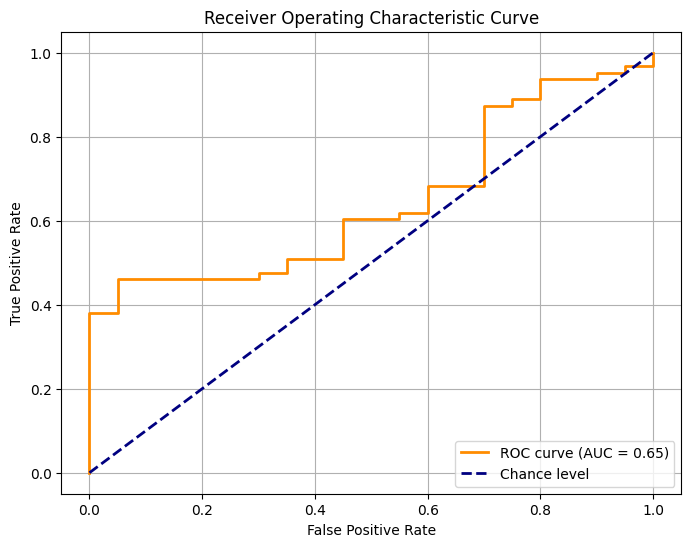

In [31]:
mae_anomali = AnomalyDetectionModel(mae_resnetmodel)


scores, labels = mae_anomali.evaluate_anomaly_detection(bottle_test_loader)

# Plotting roc curbe
plot_roc_curve(labels, scores)